<a href="https://colab.research.google.com/github/bvchand/Diabetes-detection-in-ICU-patients/blob/main/diabetes_detection_copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
import sqlite3
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer

In [69]:
from fancyimpute import IterativeImputer

### Variables Repository


*   data_dict -  data dictionary
*   diabetes_train - raw train dataset
*   diabetes_test - raw test dataset
*   diab_train_df - dataset with features (that includes null values)
*   diab_train_target - target column
*   diab_train_reduced - reduced dataset based on null threshold



In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
cd '/content/drive/Shareddrives/CMPE-255_Project/widsdatathon2021'

/content/drive/Shareddrives/CMPE-255_Project/widsdatathon2021


In [4]:
data_dict = pd.read_csv("DataDictionaryWiDS2021.csv")

In [5]:

data_dict

Category  ... Example
0            identifier  ...    None
1            identifier  ...    None
2           demographic  ...    None
3           demographic  ...    21.5
4           demographic  ...       0
..                  ...  ...     ...
176  APACHE comorbidity  ...       1
177  APACHE comorbidity  ...       1
178  APACHE comorbidity  ...       1
179  APACHE comorbidity  ...       1
180     Target Variable  ...       1

[181 rows x 6 columns]

In [6]:
diabetes_train = pd.read_csv("TrainingWiDS2021.csv")
diabetes_train_copy = diabetes_train.copy(deep=True)

In [7]:
diabetes_train

Unnamed: 0  ...  diabetes_mellitus
0                1  ...                  1
1                2  ...                  1
2                3  ...                  0
3                4  ...                  0
4                5  ...                  0
...            ...  ...                ...
130152      130153  ...                  0
130153      130154  ...                  0
130154      130155  ...                  1
130155      130156  ...                  0
130156      130157  ...                  0

[130157 rows x 181 columns]

In [8]:
diabetes_train.ethnicity.unique()

array(['Caucasian', nan, 'Hispanic', 'African American', 'Asian',
       'Native American', 'Other/Unknown'], dtype=object)

In [9]:
diabetes_train.age.describe()

count    125169.000000
mean         61.995103
std          16.822880
min           0.000000
25%          52.000000
50%          64.000000
75%          75.000000
max          89.000000
Name: age, dtype: float64

## Deepa Experimental Code


In [10]:
diabetes_train.describe().T

count  ...           max
Unnamed: 0                   130157.0  ...  130157.00000
encounter_id                 130157.0  ...  279000.00000
hospital_id                  130157.0  ...     204.00000
age                          125169.0  ...      89.00000
bmi                          125667.0  ...      67.81499
...                               ...  ...           ...
immunosuppression            130157.0  ...       1.00000
leukemia                     130157.0  ...       1.00000
lymphoma                     130157.0  ...       1.00000
solid_tumor_with_metastasis  130157.0  ...       1.00000
diabetes_mellitus            130157.0  ...       1.00000

[175 rows x 8 columns]

In [11]:
# look at missing values
missing_count=diabetes_train.isnull().sum()
missing_df = (pd.concat([missing_count,missing_count.div(len(diabetes_train))
                          .rename('Missing percent')],axis = 1)
             .loc[missing_count.ne(0)])
missing_df

#So there are quite a few missing values, use one of the strategies to fix

0  Missing percent
age                     4988         0.038323
bmi                     4490         0.034497
ethnicity               1587         0.012193
gender                    66         0.000507
height                  2077         0.015958
...                      ...              ...
h1_arterial_ph_min    107849         0.828607
h1_arterial_po2_max   107445         0.825503
h1_arterial_po2_min   107445         0.825503
h1_pao2fio2ratio_max  113397         0.871232
h1_pao2fio2ratio_min  113397         0.871232

[160 rows x 2 columns]

In [12]:
#load the test df
diabetes_test = pd.read_csv("UnlabeledWiDS2021.csv")
diabetes_test_copy = diabetes_test.copy(deep=True)
diabetes_test.describe().T

count           mean  ...        75%         max
Unnamed: 0                   10234.0    5117.500000  ...    7675.75   10234.000
encounter_id                 10234.0  140498.779461  ...  143252.75  146000.000
hospital_id                  10234.0   10092.391929  ...   10145.00   10199.000
age                          10234.0      62.853625  ...      76.00      96.000
bmi                           9219.0      29.116463  ...      32.60      69.944
...                              ...            ...  ...        ...         ...
hepatic_failure              10234.0       0.010064  ...       0.00       1.000
immunosuppression            10234.0       0.022572  ...       0.00       1.000
leukemia                     10234.0       0.006547  ...       0.00       1.000
lymphoma                     10234.0       0.004104  ...       0.00       1.000
solid_tumor_with_metastasis  10234.0       0.017686  ...       0.00       1.000

[174 rows x 8 columns]

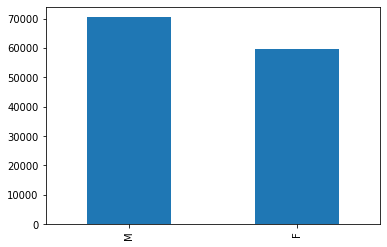

In [13]:
# drop the unnamed:0 column 
if 'Unnamed: 0' in diabetes_test.columns:
  diabetes_test = diabetes_test.drop(columns=['Unnamed: 0'])
if 'Unnamed: 0' in diabetes_train.columns:
  diabetes_test = diabetes_train.drop(columns=['Unnamed: 0'])

# look at gender distribution
gender = diabetes_train["gender"].value_counts()
gender.plot(kind="bar")

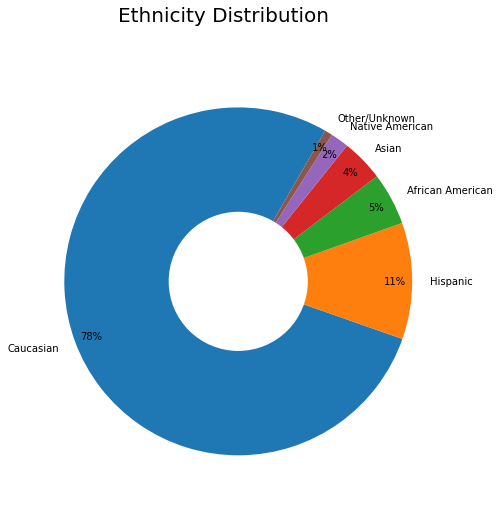

In [14]:
# look at ethnicity distribution
#diabetes_train['ethnicity'].unique() #to get values for labels
labels = ['Caucasian', 'Hispanic', 'African American', 'Asian',
       'Native American', 'Other/Unknown']
fig, ax  = plt.subplots(figsize=(16, 8))
fig.suptitle('Ethnicity Distribution', size = 20)
sizes = diabetes_train["ethnicity"].value_counts()
ax.pie(sizes, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax.add_artist(plt.Circle((0,0),0.4,fc='white'))
plt.show()


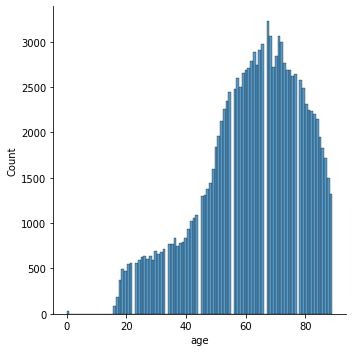

In [15]:
# look at age distribution
ax = sns.displot(diabetes_train['age']);
# looks like we have some counts against age=0
#most of the patients lie in the 60-80 age range

In [16]:
sizes

Caucasian           100236
African American     13911
Other/Unknown         6261
Hispanic              5049
Asian                 2198
Native American        915
Name: ethnicity, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


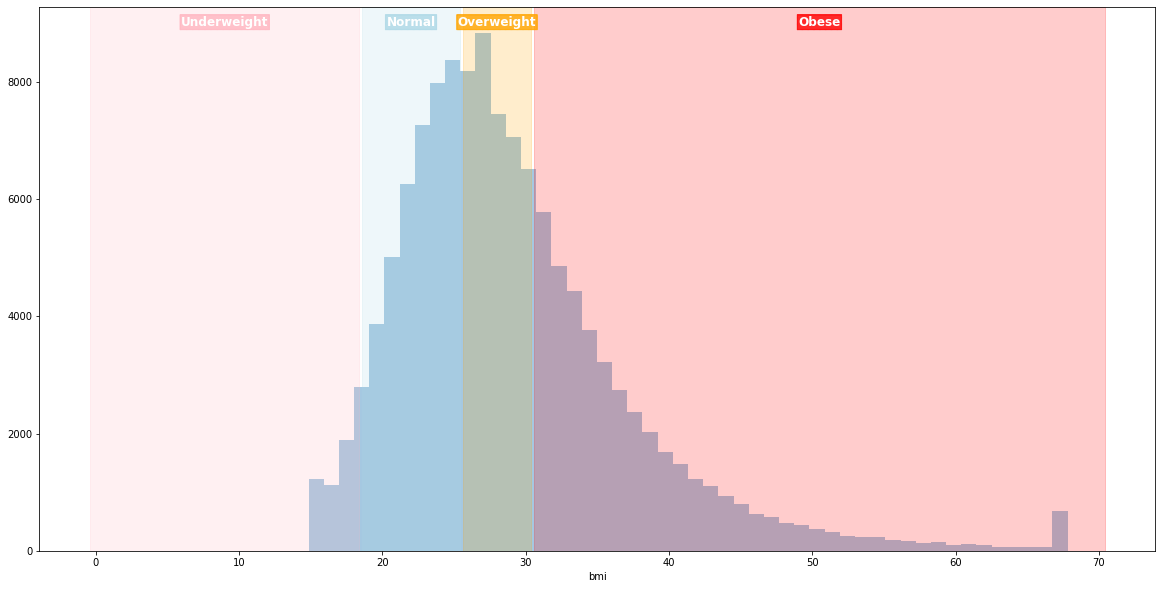

In [17]:
#BMI is important, we can see the distribution
span_range = [[0,18], [19,25], [26,30], [31,70]]
span_color =  ['#FFB6C1','#ADD8E6','orange','red']

fig, ax = plt.subplots(1,1, figsize=(20, 10))
ax = sns.distplot(diabetes_train['bmi'],kde=False);

for idx, span_title in enumerate(['Underweight','Normal','Overweight', 'Obese']):
    ax.annotate(span_title,
                    xy=(sum(span_range[idx])/2 ,1000),
                    xytext=(0,470), textcoords='offset points',
                    va="center", ha="center",
                    color="w", fontsize=10, fontweight='bold',
                    size=12,
                    bbox=dict(boxstyle='sawtooth', pad=0.1, color=span_color[idx], alpha=0.8))
    #draw a color rectangle
    ax.axvspan(span_range[idx][0]-0.4,span_range[idx][1]+0.4,  color=span_color[idx], alpha=0.2)
# plt.title("Distribution of BMI", size = 20)
plt.show()



# Ranges taken from 
#https://www.cdc.gov/obesity/adult/defining.html#:~:text=Adult%20Body%20Mass%20Index%20(BMI)&text=If%20your%20BMI%20is%20less,falls%20within%20the%20obesity%20range.

In [18]:
# Data cleanup

#Id columns not relavant for modeling, we could probably group patients by hospital if neeeded? Not dropping for now.

#check readmisssion status, looks like there is just one value in these columns
diabetes_train['readmission_status'].unique()
diabetes_test['readmission_status'].unique()

array([0])

In [19]:
#we can drop readmission status
diabetes_train = diabetes_train.drop("readmission_status",axis=1)
diabetes_test = diabetes_test.drop("readmission_status",axis=1)

In [20]:
#for missing age (age=0), replace them with median age
diabetes_train.loc[diabetes_train.age == 0, 'age'] = diabetes_train.age.median
diabetes_test.loc[diabetes_test.age == 0, 'age'] = diabetes_test.age.median

#For missing ethnicity, just add other/unknown
diabetes_train["ethnicity"] = diabetes_train["ethnicity"].fillna("Other/Unknown")
diabetes_test["ethnicity"] = diabetes_test["ethnicity"].fillna("Other/Unknown")

In [21]:
#https://www.kaggle.com/danofer/apache-iiij-icu-diagnosis-codes?select=icu-apache-codes-ANZICS.csv
#apache2 and apache3 data is present in this dataset, there is redundant information
#Action: drop the apache2 data, apache3 is more fine grained according to below paper:
#reference- https://pubmed.ncbi.nlm.nih.gov/11579607/#:~:text=Results%3A%20Both%20systems%20showed%20a,0.6856%3B%20p%20%3C%200.05).
diabetes_train['apache_3j_diagnosis'] = (diabetes_train.apache_3j_diagnosis).fillna(0).astype(int)
if "apache_2_diagnosis" in diabetes_train.columns:
  diabetes_train = diabetes_train.drop("apache_2_diagnosis",axis=1)

diabetes_test['apache_3j_diagnosis'] = (diabetes_test.apache_3j_diagnosis).fillna(0).astype(int)
if "apache_2_diagnosis" in diabetes_test.columns:
  diabetes_test = diabetes_test.drop("apache_2_diagnosis",axis=1)

In [22]:
# check correlation of the measurement data (eg albumin_apache, h1_creatinine_max), these are all floating point values
diabetes_train_fl = []

for col in diabetes_train.columns:
    if diabetes_train[col].dtype=='float64':
        diabetes_train_fl.append(col)
diabetes_train[np.intersect1d(diabetes_train.columns, diabetes_train_fl)].corr().style.background_gradient(cmap='Oranges')

## Bharathi - Handling categorical values

In [23]:
diab_train_df = diabetes_train.loc[:, diabetes_train.columns != 'diabetes_mellitus']
diab_train_target = diabetes_train['diabetes_mellitus']
diab_train_df = diab_train_df.drop(columns='Unnamed: 0')

In [24]:
X_train, X_val, y_train, y_val = train_test_split(diab_train_df, diab_train_target, test_size=0.3, random_state=42)

In [25]:
rf = RandomForestClassifier()

In [26]:
diab_train_df.columns

Index(['encounter_id', 'hospital_id', 'age', 'bmi', 'elective_surgery',
       'ethnicity', 'gender', 'height', 'hospital_admit_source',
       'icu_admit_source',
       ...
       'h1_arterial_po2_min', 'h1_pao2fio2ratio_max', 'h1_pao2fio2ratio_min',
       'aids', 'cirrhosis', 'hepatic_failure', 'immunosuppression', 'leukemia',
       'lymphoma', 'solid_tumor_with_metastasis'],
      dtype='object', length=177)

In [27]:
for cols in diab_train_df.columns:
    if(diab_train_df[cols].dtype == object):
        print("{0} : {1}".format(cols, diab_train_df[cols].dtype))

age : object
ethnicity : object
gender : object
hospital_admit_source : object
icu_admit_source : object
icu_stay_type : object
icu_type : object


In [28]:
diab_train_df[['ethnicity','gender','hospital_admit_source','icu_admit_source','icu_type']]

ethnicity gender  ...           icu_admit_source      icu_type
0              Caucasian      M  ...                      Floor         CTICU
1              Caucasian      F  ...                      Floor  Med-Surg ICU
2              Caucasian      F  ...       Accident & Emergency  Med-Surg ICU
3              Caucasian      F  ...  Operating Room / Recovery         CTICU
4              Caucasian      M  ...       Accident & Emergency  Med-Surg ICU
...                  ...    ...  ...                        ...           ...
130152         Caucasian      M  ...       Accident & Emergency   Cardiac ICU
130153         Caucasian      F  ...       Accident & Emergency          MICU
130154  African American      M  ...       Accident & Emergency   Cardiac ICU
130155         Caucasian      M  ...       Accident & Emergency  Med-Surg ICU
130156  African American      M  ...       Accident & Emergency          MICU

[130157 rows x 5 columns]

In [29]:
obj_cols = {'ethnicity','gender','hospital_admit_source','icu_admit_source','icu_type', 'icu_stay_type'}
for col in obj_cols:
    print("{0}: {1}".format(col, diab_train_df[col].unique()))

icu_type: ['CTICU' 'Med-Surg ICU' 'CCU-CTICU' 'Neuro ICU' 'MICU' 'SICU'
 'Cardiac ICU' 'CSICU']
icu_admit_source: ['Floor' 'Accident & Emergency' 'Operating Room / Recovery'
 'Other Hospital' 'Other ICU' nan]
hospital_admit_source: ['Floor' 'Emergency Department' 'Operating Room' nan 'Direct Admit'
 'Other Hospital' 'Other ICU' 'ICU to SDU' 'Recovery Room'
 'Chest Pain Center' 'Step-Down Unit (SDU)' 'Acute Care/Floor' 'PACU'
 'Observation' 'ICU' 'Other']
gender: ['M' 'F' nan]
icu_stay_type: ['admit' 'readmit' 'transfer']
ethnicity: ['Caucasian' 'Other/Unknown' 'Hispanic' 'African American' 'Asian'
 'Native American']


#### Handling missing values:



In [30]:
diab_train_df[['gender']].head()

gender
0      M
1      F
2      F
3      F
4      M

In [31]:
diab_train_df['gender'].isnull().sum()

66

In [32]:
diab_train_df['gender'] = diab_train_df['gender'].fillna(method='ffill')

In [33]:
diab_train_df['gender'].isnull().sum()

0

In [34]:
diab_train_df['ethnicity'].isnull().sum()

0

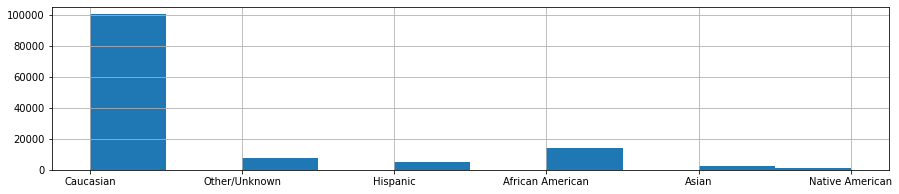

In [35]:
diab_train_df['ethnicity'].hist(figsize=(15,3))

In [36]:
diab_train_df['ethnicity'].replace(np.nan, "Unknown", inplace=True)
diab_train_df['ethnicity'].isnull().sum()

0

In [37]:
diab_train_df['icu_type'].isnull().sum()

0

In [38]:
diab_train_df['icu_admit_source'].isnull().sum()

240

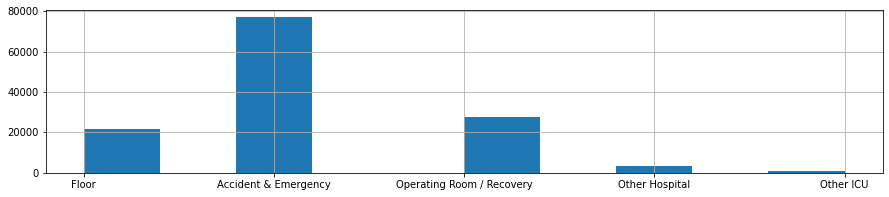

In [39]:
diab_train_df['icu_admit_source'].hist(figsize=(15,3))

In [40]:
diab_train_df['icu_admit_source'].replace(np.nan, "Unknown", inplace=True)
diab_train_df['icu_admit_source'].isnull().sum()

0

In [41]:
diab_train_df['hospital_admit_source'].isnull().sum()

33198

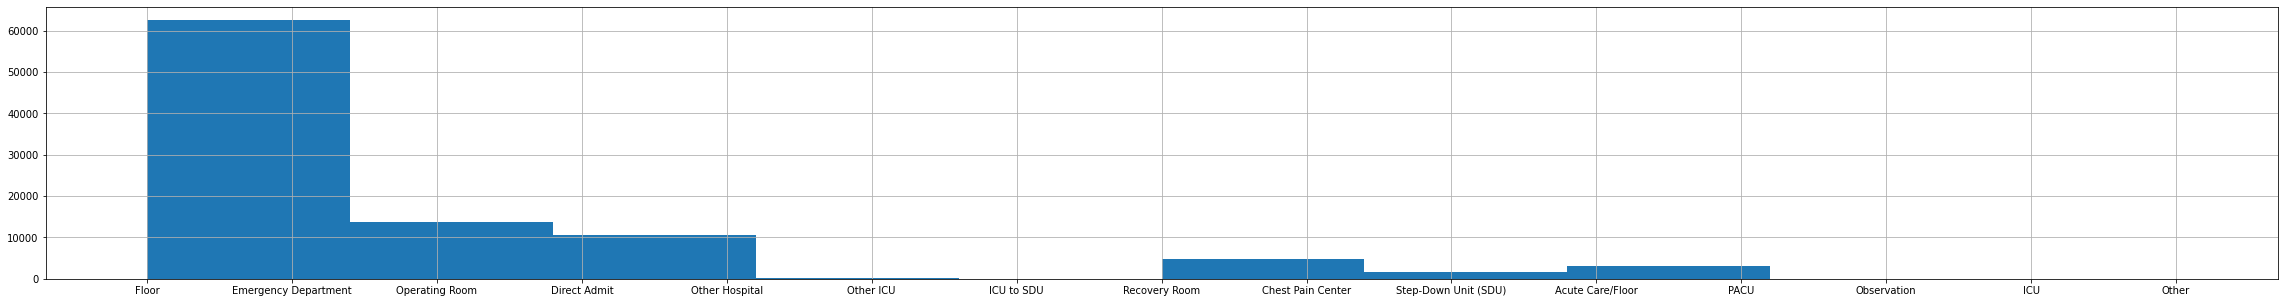

In [42]:
diab_train_df['hospital_admit_source'].hist(figsize=(40,5))

In [43]:
diab_train_df['hospital_admit_source'].replace(np.nan, "Unknown", inplace=True)
diab_train_df['hospital_admit_source'].isnull().sum()

0

In [44]:
diab_train_df['icu_stay_type'].isnull().sum()

0

In [45]:
for col in obj_cols:
    print("{0}: {1}".format(col, diab_train_df[col].unique()))

icu_type: ['CTICU' 'Med-Surg ICU' 'CCU-CTICU' 'Neuro ICU' 'MICU' 'SICU'
 'Cardiac ICU' 'CSICU']
icu_admit_source: ['Floor' 'Accident & Emergency' 'Operating Room / Recovery'
 'Other Hospital' 'Other ICU' 'Unknown']
hospital_admit_source: ['Floor' 'Emergency Department' 'Operating Room' 'Unknown' 'Direct Admit'
 'Other Hospital' 'Other ICU' 'ICU to SDU' 'Recovery Room'
 'Chest Pain Center' 'Step-Down Unit (SDU)' 'Acute Care/Floor' 'PACU'
 'Observation' 'ICU' 'Other']
gender: ['M' 'F']
icu_stay_type: ['admit' 'readmit' 'transfer']
ethnicity: ['Caucasian' 'Other/Unknown' 'Hispanic' 'African American' 'Asian'
 'Native American']


### Encoding categorical features:

In [46]:
enc = LabelEncoder()
for cols in obj_cols:
    diab_train_df[cols] = enc.fit_transform(diab_train_df[cols])    

In [47]:
for col in obj_cols:
    print("{0}: {1}".format(col, diab_train_df[col].unique()))

icu_type: [2 5 0 6 4 7 3 1]
icu_admit_source: [1 0 2 3 4 5]
hospital_admit_source: [ 4  3  8 15  2 10 11  6 13  1 14  0 12  7  5  9]
gender: [1 0]
icu_stay_type: [0 1 2]
ethnicity: [2 5 3 0 1 4]


### Feature selection using mutual information

In [48]:
# from sklearn.feature_selection import mutual_info_classif
# threshold = 5  # the number of most relevant features
# high_score_features = []
# feature_scores = mutual_info_classif(diab_train_df, diab_train_target, random_state=0)
# for score, f_name in sorted(zip(feature_scores, diab_train_df.columns), reverse=True)[:threshold]:
#         print(f_name, score)
#         high_score_features.append(f_name)
# diab_train_df_mic = diab_train_df[high_score_features]
# print(diab_train_df_mic.columns)

In [218]:
def missing_percentage(df):
    missing_count=diab_train_df.isnull().sum()
    missing_df = (pd.concat([missing_count.rename('Missing count'),missing_count.div(len(diab_train_df))
                .rename('Missing percent')],axis = 1))
    missing_df.style.background_gradient(cmap="Blues")

    return missing_df

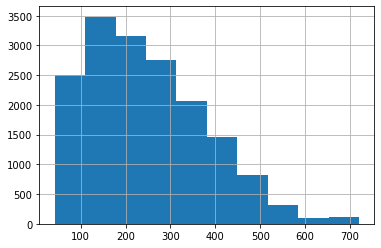

In [50]:
diab_train_df['h1_pao2fio2ratio_max'].hist()

In [51]:
diab_train_df['h1_pao2fio2ratio_max'].describe()

count    16760.000000
mean       247.525419
std        131.440167
min         42.000000
25%        144.000000
50%        228.125000
75%        333.000000
max        720.000000
Name: h1_pao2fio2ratio_max, dtype: float64

In [52]:
diab_train_df['h1_pao2fio2ratio_max'].fillna(method='ffill', inplace=True)

In [53]:
diab_train_df['h1_pao2fio2ratio_max'].describe()

count    130156.000000
mean        246.967683
std         131.797058
min          42.000000
25%         144.000000
50%         226.000000
75%         334.000000
max         720.000000
Name: h1_pao2fio2ratio_max, dtype: float64

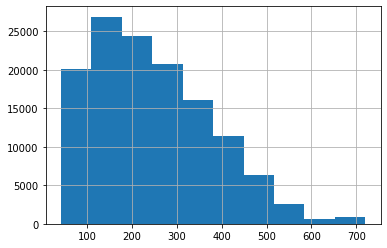

In [54]:
diab_train_df['h1_pao2fio2ratio_max'].hist()

### MICE implementation

In [88]:
diab_train_df_copy = diab_train_df.copy(deep=True)
diab_train_df_copy = diab_train_df_copy.drop(columns='age')
MICE = IterativeImputer(verbose=0)
diab_train_df_copy = MICE.fit_transform(diab_train_df_copy)


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in vers

In [94]:
cols = diab_train_df.columns
cols = [c for c in cols if c != 'age']

In [96]:
diab_train_df_imputed = pd.DataFrame(diab_train_df_copy, columns=cols)

In [97]:
diab_train_df_imputed

encounter_id  hospital_id  ...  lymphoma  solid_tumor_with_metastasis
0           214826.0        118.0  ...       0.0                          0.0
1           246060.0         81.0  ...       0.0                          0.0
2           276985.0        118.0  ...       0.0                          0.0
3           262220.0        118.0  ...       0.0                          0.0
4           201746.0         33.0  ...       0.0                          0.0
...              ...          ...  ...       ...                          ...
130152      164758.0          7.0  ...       0.0                          0.0
130153      197653.0          7.0  ...       0.0                          0.0
130154      219719.0          7.0  ...       0.0                          0.0
130155      222562.0        170.0  ...       0.0                          0.0
130156      157942.0          7.0  ...       0.0                          0.0

[130157 rows x 176 columns]

In [103]:
diab_train_df_imputed['h1_pao2fio2ratio_max'].describe()

count    130157.000000
mean        247.233079
std         162.904694
min          42.000000
25%         144.000000
50%         226.000000
75%         334.000000
max       34790.105611
Name: h1_pao2fio2ratio_max, dtype: float64

In [104]:
diab_train_df['h1_pao2fio2ratio_max'].describe()

count    130156.000000
mean        246.967683
std         131.797058
min          42.000000
25%         144.000000
50%         226.000000
75%         334.000000
max         720.000000
Name: h1_pao2fio2ratio_max, dtype: float64

### Drop cols with null values

In [232]:
diab_train_reduced = diab_train_df.copy(deep=True)

In [233]:
missing_df = missing_percentage(diab_train_df)
missing_df

Missing count  Missing percent
encounter_id                             0         0.000000
hospital_id                              0         0.000000
age                                   4988         0.038323
bmi                                   4490         0.034497
elective_surgery                         0         0.000000
...                                    ...              ...
hepatic_failure                          0         0.000000
immunosuppression                        0         0.000000
leukemia                                 0         0.000000
lymphoma                                 0         0.000000
solid_tumor_with_metastasis              0         0.000000

[177 rows x 2 columns]

In [234]:
cols_above_threshold = missing_df[missing_df['Missing percent']>0.3]

In [230]:
cols_above_threshold

Missing count  Missing percent
albumin_apache                78163         0.600529
bilirubin_apache              82560         0.634311
fio2_apache                   99720         0.766152
paco2_apache                  99720         0.766152
paco2_for_ph_apache           99720         0.766152
...                             ...              ...
h1_arterial_ph_max           107849         0.828607
h1_arterial_ph_min           107849         0.828607
h1_arterial_po2_max          107445         0.825503
h1_arterial_po2_min          107445         0.825503
h1_pao2fio2ratio_min         113397         0.871232

[73 rows x 2 columns]

In [235]:
diab_train_reduced.drop(columns=cols_above_threshold.index)

encounter_id  hospital_id  ... lymphoma  solid_tumor_with_metastasis
0             214826          118  ...        0                            0
1             246060           81  ...        0                            0
2             276985          118  ...        0                            0
3             262220          118  ...        0                            0
4             201746           33  ...        0                            0
...              ...          ...  ...      ...                          ...
130152        164758            7  ...        0                            0
130153        197653            7  ...        0                            0
130154        219719            7  ...        0                            0
130155        222562          170  ...        0                            0
130156        157942            7  ...        0                            0

[130157 rows x 104 columns]

Sahithi - data exploration

In [55]:
diabetes_train.columns

Index(['Unnamed: 0', 'encounter_id', 'hospital_id', 'age', 'bmi',
       'elective_surgery', 'ethnicity', 'gender', 'height',
       'hospital_admit_source',
       ...
       'h1_pao2fio2ratio_max', 'h1_pao2fio2ratio_min', 'aids', 'cirrhosis',
       'hepatic_failure', 'immunosuppression', 'leukemia', 'lymphoma',
       'solid_tumor_with_metastasis', 'diabetes_mellitus'],
      dtype='object', length=179)

In [56]:
diabetes_train.info

<bound method DataFrame.info of         Unnamed: 0  ...  diabetes_mellitus
0                1  ...                  1
1                2  ...                  1
2                3  ...                  0
3                4  ...                  0
4                5  ...                  0
...            ...  ...                ...
130152      130153  ...                  0
130153      130154  ...                  0
130154      130155  ...                  1
130155      130156  ...                  0
130156      130157  ...                  0

[130157 rows x 179 columns]>

In [57]:
diabetes_train.dtypes.value_counts()

float64    154
int64       18
object       7
dtype: int64

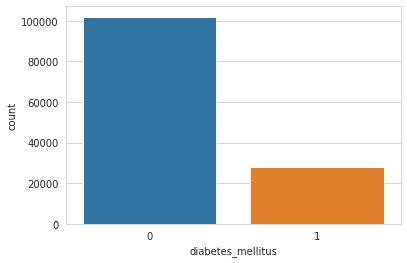

In [58]:
#plot to get an idea of target variable distribution
sns.set_style("whitegrid")
sns.countplot(x='diabetes_mellitus',data=diabetes_train)

In [59]:
diabetes_train['icu_admit_source']

0                             Floor
1                             Floor
2              Accident & Emergency
3         Operating Room / Recovery
4              Accident & Emergency
                    ...            
130152         Accident & Emergency
130153         Accident & Emergency
130154         Accident & Emergency
130155         Accident & Emergency
130156         Accident & Emergency
Name: icu_admit_source, Length: 130157, dtype: object

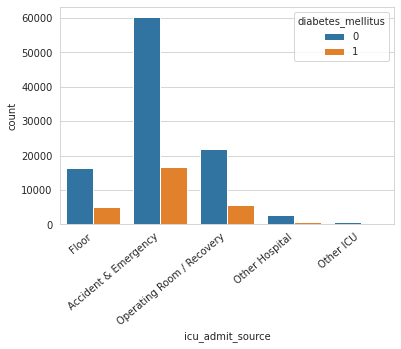

In [60]:
#plot to know the relationship of 'icu_addmit_source' with target.
#We can use same plot for other attributes while deciding on feature selection
ax=sns.countplot(x='icu_admit_source',hue='diabetes_mellitus',data=diabetes_train)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()


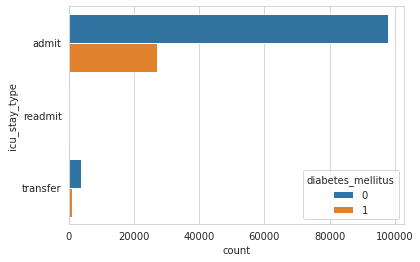

In [61]:
#plot to know the relationship of 'icu_stay_type' with target.
sns.countplot(y='icu_stay_type',hue='diabetes_mellitus',data=diabetes_train)

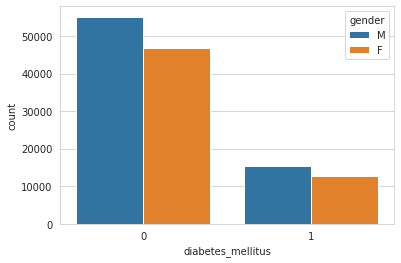

In [62]:
#plot to know the relationship of 'gender' with target.
sns.countplot(x='diabetes_mellitus',hue='gender',data=diabetes_train)

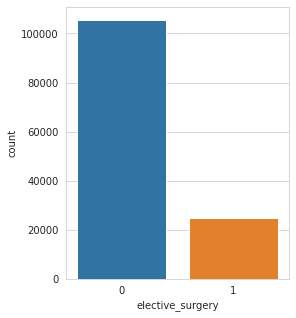

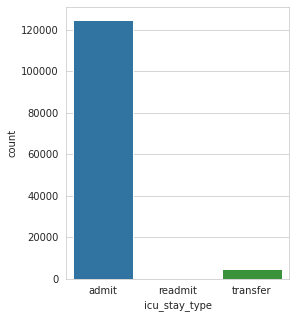

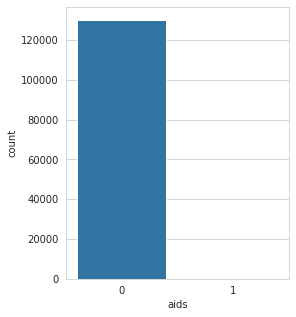

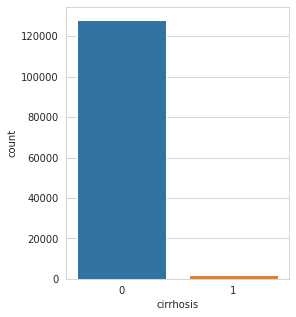

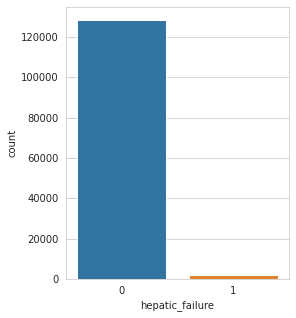

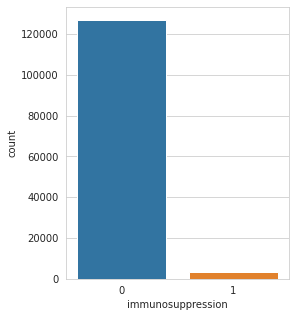

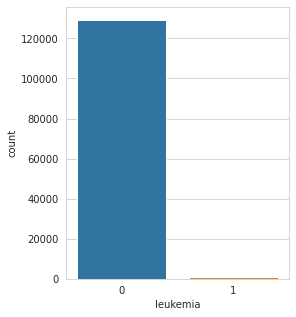

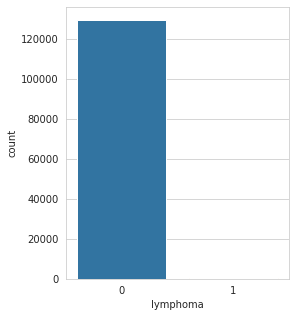

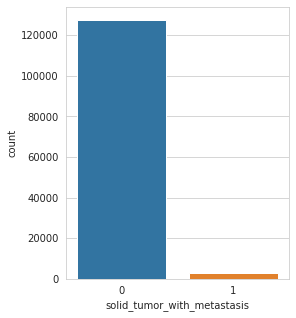

In [63]:
columns_to_drop = ['elective_surgery','icu_stay_type','aids','cirrhosis','hepatic_failure','immunosuppression','leukemia','lymphoma','solid_tumor_with_metastasis']

for col in columns_to_drop:
  plt.figure(figsize=(4,5))
  sns.countplot(x=col, data=diabetes_train)
  plt.show()


In [64]:
columns_to_drop = ['hospital_id','elective_surgery','icu_id','icu_stay_type','icu_type','aids','cirrhosis','hepatic_failure','immunosuppression','leukemia','lymphoma','solid_tumor_with_metastasis']